# <u>Data Science Essentials</u>

## <u>Topic</u>: Probability Calibration

## <u>Category</u>: Model Training

### <u>Created By</u>: Mohammed Misbahullah Sheriff
- [LinkedIn](https://www.linkedin.com/in/mohammed-misbahullah-sheriff/)
- [GitHub](https://github.com/MisbahullahSheriff)

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
)

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.calibration import (
    calibration_curve,
    CalibratedClassifierCV
)

## Getting the Data

In [ ]:
path = "/content/titanic.csv"

df = pd.read_csv(path)
print("Data Shape:", df.shape)
df.head()

Data Shape: (891, 9)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck
0,0,3,male,22.0,1,0,7.2500,S,NaN
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,NaN
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,NaN


In [ ]:
X = df.drop(columns="survived")
y = df.survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 8) (712,)
(179, 8) (179,)


## Demo

### Data Preprocessing

In [ ]:
num_cols = X.select_dtypes(include="number").columns
obj_cols = X.select_dtypes(exclude="number").columns

num_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

num_pipe = Pipeline(steps=[("imputer", num_imputer),
                           ("scaler", scaler)])

obj_imputer = SimpleImputer(strategy="most_frequent")
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

obj_pipe = Pipeline(steps=[("imputer", obj_imputer),
                           ("encoder", encoder)])

preprocessor = ColumnTransformer(transformers=[("num", num_pipe, num_cols),
                                               ("obj", obj_pipe, obj_cols)])

model = Pipeline(steps=[("pre", preprocessor),
                        ("clf", RandomForestClassifier())])

### Calibration Curve - before calibration of probabilities

In [ ]:
def plot_curves(y, y_pred):
  """

  Description:
  ------------
  This function will plot the calibration curve for given predicted probabilties

  Parameters:
  -----------
  y: array
     True labels

  y_pred: array
          Predicted probabilities of positive class

  """
  prob_true, prob_pred = calibration_curve(y, y_pred, n_bins=10)

  plt.figure(figsize=(6, 4))

  plt.plot([0, 1],
           [0, 1],
           linestyle=":",
           color="black",
           label="Ideal")

  plt.plot(prob_pred,
           prob_true,
           color="blue",
           marker="s",
           label="Model")

  plt.title("Calibration Curve")
  plt.xlabel("Mean Predicted Probability")
  plt.ylabel("Fraction of Positive Samples")

  plt.grid(True)

  plt.legend(loc="upper left")

  plt.show()

In [ ]:
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)
y_probs[:5]

array([[0.86 , 0.14 ],
       [0.91 , 0.09 ],
       [0.88 , 0.12 ],
       [0.965, 0.035],
       [0.17 , 0.83 ]])

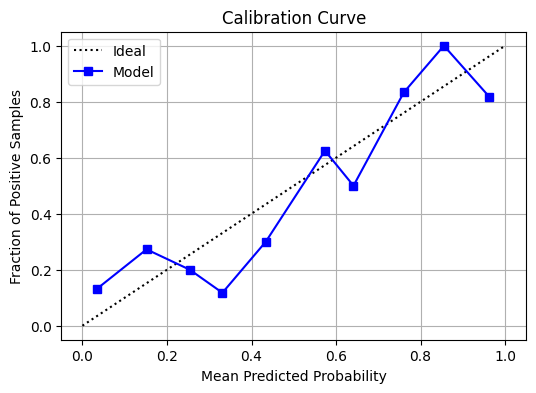

In [ ]:
plot_curves(y_test, y_probs[:, 1])

In [ ]:
model.score(X_test, y_test)

0.8212290502793296

### Calibration Curve - after calibration of probabilities

In [ ]:
calibrated_model = CalibratedClassifierCV(model,
                                          method="sigmoid",
                                          cv=5,
                                          n_jobs=-1,
                                          ensemble=False)

calibrated_model.fit(X_train, y_train)
y_calib_probs = calibrated_model.predict_proba(X_test)
y_calib_probs[:5]

array([[0.86423306, 0.13576694],
       [0.88661733, 0.11338267],
       [0.83623329, 0.16376671],
       [0.89924898, 0.10075102],
       [0.2330548 , 0.7669452 ]])

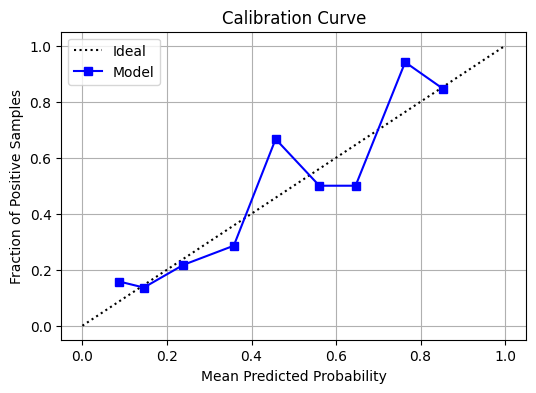

In [ ]:
plot_curves(y_test, y_calib_probs[:, 1])

In [ ]:
calibrated_model.score(X_test, y_test)

0.7988826815642458

### Observation:

- As evident from above, the curve of the calibrated model is closer to the ideal curve than the non-calibrated model
- Calibration of classifiers is crucial if the goal is to interpret the predicted probabilities of the model